In [1]:
!nvidia-smi

Thu May 23 15:32:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          Off | 00000000:3B:00.0 Off |                    0 |
| N/A   50C    P0              41W / 250W |   7964MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install accelerate peft transformers trl bitsandbytes
!pip install sentencepiece
!pip install evaluate rouge_score nltk

## Import libraries

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use the first GPU
import numpy as np
import json
import re
from pprint import pprint
import evaluate
import nltk
from nltk.tokenize import (
    sent_tokenize,
    wordpunct_tokenize,
    word_tokenize,
    )
from nltk.corpus import stopwords
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
)

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    MBart50Tokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
)
from trl import SFTTrainer
import matplotlib.pyplot as plt

2024-05-23 15:32:43.904767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 15:32:44.063109: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 15:32:44.097731: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 15:32:44.778096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
rouge_score = evaluate.load('rouge')
bleu_score = evaluate.load('bleu')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Setup execution environment

In [4]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    device_map = {"": 0}
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


## Functions

In [6]:
SOURCE_NAME = 'source'
TARGET_NAME = 'target'
INSTRUCTION = "Riassumi il seguente articolo"

### Utilities

In [7]:
def generate_text(data_point):
    summary = data_point[SOURCE_NAME]
    text = ""
    for item in data_point[TARGET_NAME]:
        text_clean = clean_text(item)
        text += text_clean.strip()

def flatten(nested_list):
    return [' '.join(sublist) for sublist in nested_list]

### Text Cleaning

In [8]:
def remove_symbols(text):
    result = wordpunct_tokenize(text)
    remove_element = '!"$\'%(),.:;?l[]{}@€#<>*+-=/_'
    filtered_result = [word.lower() for word in result if word not in remove_element]
    return ' '.join(filtered_result)

def replace_newline(text):
    return text.replace('\n', ' ')

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_non_alphanumeric(text):
    return ''.join([i for i in text if i.isalpha() or i.isspace()])

def lowercase(text):
    return text.lower()

def remove_emojis(text):
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  # emoticoni generici
                               u"\U0001F300-\U0001F5FF"  # simboli & pictogrammi
                               u"\U0001F680-\U0001F6FF"  # simboli del trasporto & mappe
                               u"\U0001F1E0-\U0001F1FF"  # bandiere (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = remove_symbols(text)
    text = replace_newline(text)
    text = remove_stopwords(text)
    text = remove_non_alphanumeric(text)
    text = lowercase(text)
    text = remove_emojis(text)
    return text

def dataset_clean(data: Dataset):
    def preprocess_example(example):
        example[SOURCE_NAME] = clean_text(example[SOURCE_NAME])
        example[TARGET_NAME] = clean_text(example[TARGET_NAME])
        return example

    return (
        data.shuffle(seed=42)
            .map(preprocess_example)
            .map(generate_text)
            #.remove_columns(
            #  [
            #    "url",
            #    "title",
            #    "materia",
            # ]
        )
    #)

### Tokenization

In [9]:
def preprocess_function(examples, tokenizer, max_source_length, max_target_length):
    # Flatten the documents if necessary
    if isinstance(examples[SOURCE_NAME][0], list):
        docs = flatten(examples[SOURCE_NAME])
    else:
        docs = examples[SOURCE_NAME]
    inputs = [doc for doc in docs]
    model_inputs = tokenizer(inputs, truncation=True, padding=True, return_tensors="pt")

    # Flatten the summaries if necessary
    if isinstance(examples[TARGET_NAME][0], list):
        summaries = flatten(examples[TARGET_NAME])
    else:
        summaries = examples[TARGET_NAME]
    labels = tokenizer(summaries, truncation=True, padding=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

    # Flatten the summaries if necessary
    summaries = flatten(examples[TARGET_NAME])
    labels = tokenizer(summaries, truncation=True, padding=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

### Metrics

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result_rouge = rouge_score.compute(
      predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )

    result_bleu = bleu_score.compute(
      predictions=decoded_preds, references=decoded_labels
    )

    result_rouge = {key: value for key, value in result_rouge.items()}
    result_rouge = {k: round(v, 4) for k, v in result_rouge.items()}
    return {"rouge": result_rouge, "bleu": result_bleu}

## Fine-tuning


In [11]:
base_model = "facebook/mbart-large-50"
dataset_name = "ARTeLab/fanpage"
base_path="./LLM_BISS2024/mBART"
#/TinyLLama"

output_dir = f"{base_path}/{base_model}.finetuned.{dataset_name}"

new_model = f"{base_model}.finetuned.{dataset_name}"

### Dataset

In [12]:
dataset = load_dataset(dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 67492
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 8436
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 8437
    })
})

In [13]:
dataset_train = dataset['train']
dataset_validation = dataset['validation']

### Length of the news before cleaning

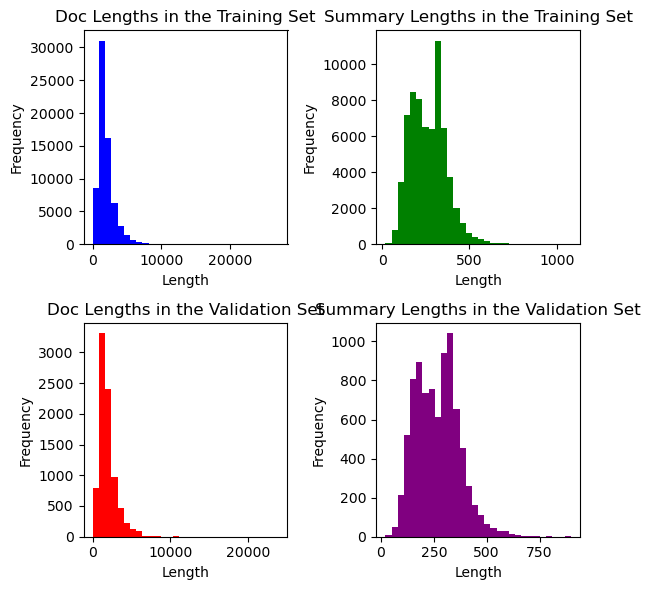

In [14]:
# Calculate the lengths of the phrases in the training and validation sets
train_lengths_doc = [len(item['source']) for item in dataset['train']]
train_lengths_summary = [len(item['target']) for item in dataset['train']]
validation_lengths_doc = [len(item['source']) for item in dataset['validation']]
validation_lengths_summary = [len(item['target']) for item in dataset['validation']]

# Create a histogram for each set
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.hist(train_lengths_doc, bins=30, color='blue')
plt.title('Doc Lengths in the Training Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(train_lengths_summary, bins=30, color='green')
plt.title('Summary Lengths in the Training Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(validation_lengths_doc, bins=30, color='red')
plt.title('Doc Lengths in the Validation Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(validation_lengths_summary, bins=30, color='purple')
plt.title('Summary Lengths in the Validation Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Dataset cleaning

In [15]:
dataset_train_clean = dataset_clean(dataset_train)
dataset_validation_clean = dataset_clean(dataset_validation)

Map:   0%|          | 0/67492 [00:00<?, ? examples/s]

Map:   0%|          | 0/8436 [00:00<?, ? examples/s]

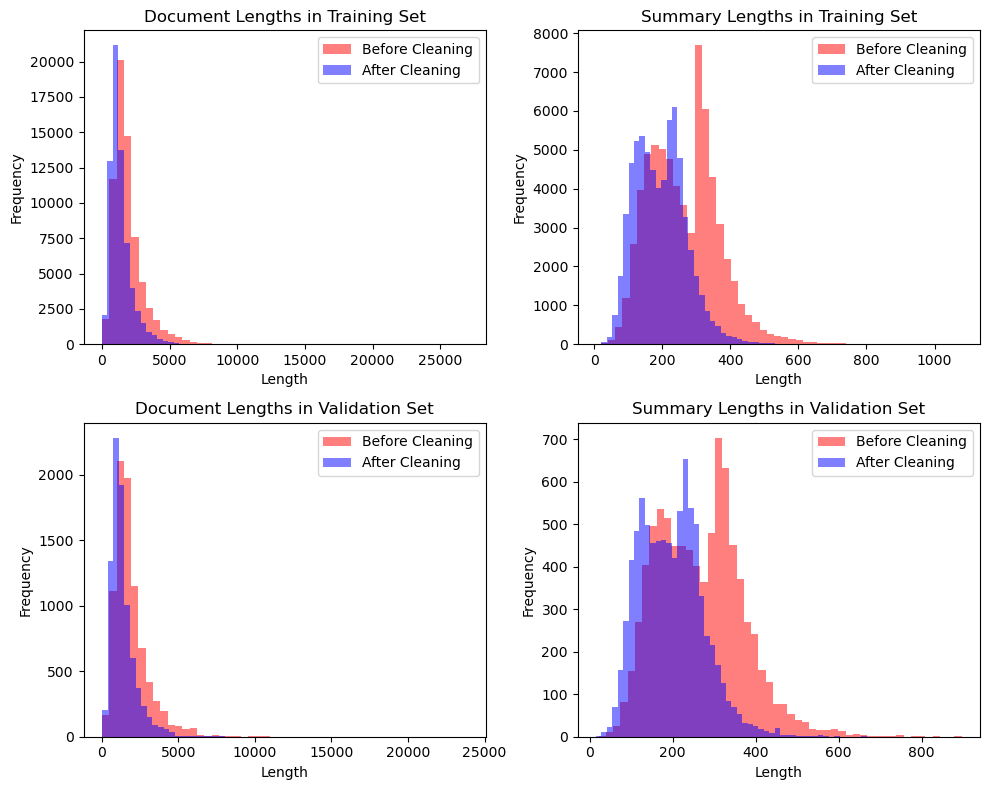

In [16]:
train_lengths_doc_before_cleaning = [len(item[SOURCE_NAME]) for item in dataset_train]
train_lengths_summary_before_cleaning = [len(item[TARGET_NAME]) for item in dataset_train]
validation_lengths_doc_before_cleaning = [len(item[SOURCE_NAME]) for item in dataset_validation]
validation_lengths_summary_before_cleaning = [len(item[TARGET_NAME]) for item in dataset_validation]

cleaned_train_lengths_doc = [len(item[SOURCE_NAME]) for item in dataset_train_clean]
cleaned_train_lengths_summary = [len(item[TARGET_NAME]) for item in dataset_train_clean]
cleaned_validation_lengths_doc = [len(item[SOURCE_NAME]) for item in dataset_validation_clean]
cleaned_validation_lengths_summary = [len(item[TARGET_NAME]) for item in dataset_validation_clean]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico per il dataset di addestramento
axs[0, 0].hist(train_lengths_doc_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[0, 0].hist(cleaned_train_lengths_doc, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[0, 0].set_title('Document Lengths in Training Set')
axs[0, 0].set_xlabel('Length')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

axs[0, 1].hist(train_lengths_summary_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[0, 1].hist(cleaned_train_lengths_summary, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[0, 1].set_title('Summary Lengths in Training Set')
axs[0, 1].set_xlabel('Length')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Grafico per il dataset di validazione
axs[1, 0].hist(validation_lengths_doc_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[1, 0].hist(cleaned_validation_lengths_doc, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[1, 0].set_title('Document Lengths in Validation Set')
axs[1, 0].set_xlabel('Length')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

axs[1, 1].hist(validation_lengths_summary_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[1, 1].hist(cleaned_validation_lengths_summary, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[1, 1].set_title('Summary Lengths in Validation Set')
axs[1, 1].set_xlabel('Length')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [17]:
max_length_doc_before_cleaning = max(train_lengths_doc_before_cleaning)
max_length_summary_before_cleaning = max(train_lengths_summary_before_cleaning)

max_length_doc_after_cleaning = max(cleaned_train_lengths_doc)
max_length_summary_after_cleaning = max(cleaned_train_lengths_summary)

print("Max length before cleaning for the training dataset:")
print(f"Max length of the text: {max_length_doc_before_cleaning}")
print(f"Max length of the summary: {max_length_summary_before_cleaning}")

print("Max length after cleaning for the training dataset:")
print(f"Max length of the text: {max_length_doc_after_cleaning}")
print(f"Max length of the summary: {max_length_summary_after_cleaning}")

max_length_doc_before_cleaning_val = max(validation_lengths_doc_before_cleaning)
max_length_summary_before_cleaning_val = max(validation_lengths_summary_before_cleaning)

max_length_doc_after_cleaning_val = max(cleaned_validation_lengths_doc)
max_length_summary_after_cleaning_val = max(cleaned_validation_lengths_summary)

print("\nMax length before cleaning for the validation dataset:")
print(f"Max length of the text: {max_length_doc_before_cleaning_val}")
print(f"Max length of the summary: {max_length_summary_before_cleaning_val}")

print("Max length after cleaning for the validation dataset:")
print(f"Max length of the text: {max_length_doc_after_cleaning_val}")
print(f"Max length of the summary: {max_length_summary_after_cleaning_val}")

Max length before cleaning for the training dataset:
Max length of the text: 27019
Max length of the summary: 1080
Max length after cleaning for the training dataset:
Max length of the text: 20377
Max length of the summary: 802

Max length before cleaning for the validation dataset:
Max length of the text: 23893
Max length of the summary: 897
Max length after cleaning for the validation dataset:
Max length of the text: 18344
Max length of the summary: 668


In [18]:
original_train_lengths_source = [len(item[SOURCE_NAME]) for item in dataset_train]
original_train_lengths_target = [len(item[TARGET_NAME]) for item in dataset_train]

cleaned_train_lengths_source = [len(item[SOURCE_NAME]) for item in dataset_train_clean]
cleaned_train_lengths_target = [len(item[TARGET_NAME]) for item in dataset_train_clean]

mean_original_length_source = sum(original_train_lengths_source) / len(original_train_lengths_source)
mean_cleaned_length_source = sum(cleaned_train_lengths_source) / len(cleaned_train_lengths_source)

mean_original_length_target = sum(original_train_lengths_target) / len(original_train_lengths_target)
mean_cleaned_length_target = sum(cleaned_train_lengths_target) / len(cleaned_train_lengths_target)

reduction_percentage_source = ((mean_original_length_source - mean_cleaned_length_source) / mean_original_length_source) * 100
reduction_percentage_target = ((mean_original_length_target - mean_cleaned_length_target) / mean_original_length_target) * 100

print("Percentuale media di riduzione della lunghezza per 'source':", reduction_percentage_source)
print("Percentuale media di riduzione della lunghezza per 'target':", reduction_percentage_target)

Percentuale media di riduzione della lunghezza per 'source': 27.66236781227694
Percentuale media di riduzione della lunghezza per 'target': 26.42877213987569


### Preparing the data

In [19]:
finetuning_train_dataset = dataset_train_clean.select(range(1000))
finetuning_validation_dataset= dataset_validation_clean.select(range(500))

### Tokenization


In [20]:
#tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer = MBart50Tokenizer.from_pretrained(base_model, src_lang="it_IT", tgt_lang="it_IT")
print(f'Vocabulary size: {tokenizer.vocab_size}')

Vocabulary size: 250054


In [21]:
max_source_length = 1024
max_target_length = 512
tokenized_train_dataset = finetuning_train_dataset.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_source_length": max_source_length,
        "max_target_length": max_target_length
    },
    batched=True,
    remove_columns=["source", "target"]
)

tokenized_valid_dataset = finetuning_validation_dataset.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_source_length": max_source_length,
        "max_target_length": max_target_length
    },
    batched=True,
    remove_columns=[SOURCE_NAME, TARGET_NAME]
)

In [22]:
max_token_length = max(len(tokens) for tokens in tokenized_train_dataset['input_ids'])
print(f"Maximum token length in the training dataset: {max_token_length}")
max_token_length = max(len(tokens) for tokens in tokenized_valid_dataset['input_ids'])
print(f"Maximum token length in the training dataset: {max_token_length}")

Maximum token length in the training dataset: 1024
Maximum token length in the training dataset: 1024


### Training


In [23]:
batch_size =22
micro_batch_size = 8
num_train_epochs = 10
warmup_ratio = 0.1
logging_steps = 10
gradient_accumulation_steps = batch_size // micro_batch_size

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #learning_rate=5.6e-5,
    learning_rate = 1e-7,
    per_device_train_batch_size=micro_batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    warmup_ratio = warmup_ratio,
    optim = "adamw_torch",
    save_total_limit=1,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_strategy="steps",
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    quantization_config = quantization_config,
    device_map= device_map
    )

In [25]:
!ls /home/anna.vitali7/persistent/bitsandbytes/bitsandbytes/libbitsandbytes_cpu.so

ls: cannot access '/home/anna.vitali7/persistent/bitsandbytes/bitsandbytes/libbitsandbytes_cpu.so': No such file or directory


In [26]:
peft_config = LoraConfig(
    task_type='SEQ_2_SEQ_LM',
    inference_mode=False, r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
])
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 612,648,960 || trainable%: 0.2888


In [27]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
features = [tokenized_train_dataset[i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[250011,  22688, 198631,  ...,      1,      1,      1],
        [250011,  20809, 106985,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[250011,   1909,  27651,   8623, 101471,  22029, 192083,     10,  79660,
           3478,  58434,    538,     34,   4834,  22029,  22688,   2062,   1760,
           3671,   3666, 198631,  69686,    102,    405,    408,  13120,  40865,
            148,    102,   1777,    458,    188,   5423,     57, 134903,   3398,
          20446,    188,  14858,   6275,   7996,   6864,  19407, 208263,   1226,
           3139,  82690,   7793,    433,   6599,     91,  18064,   7070,    102,
             97,  12667,   8993,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,     

In [29]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
model.config.use_cache = False

#model.config.pad_token_id = 0
#model.config.bos_token_id = 1
#model.config.eos_token_id = 2

# speeds up training
if torch.__version__ >= "2":
    model = torch.compile(model)

In [30]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [31]:
trainer.train()
model.save_pretrained(output_dir)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: martinaianaro-tesi (pictobert). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge,Bleu
0,14.979200,12.991753,"{'rouge1': 0.2038, 'rouge2': 0.0931, 'rougeL': 0.1504, 'rougeLsum': 0.1502}","{'bleu': 0.04471587547347561, 'precisions': [0.12374072347900907, 0.05645190464131968, 0.029478333880918483, 0.01941568728585639], 'brevity_penalty': 1.0, 'length_ratio': 4.585778873818331, 'translation_length': 55786, 'reference_length': 12165}"
2,14.957300,12.984081,"{'rouge1': 0.2038, 'rouge2': 0.0931, 'rougeL': 0.1504, 'rougeLsum': 0.1503}","{'bleu': 0.044665068908160695, 'precisions': [0.12361924199294627, 0.05639756489694167, 0.029440180833804255, 0.019390326912817116], 'brevity_penalty': 1.0, 'length_ratio': 4.591615289765722, 'translation_length': 55857, 'reference_length': 12165}"
4,14.997900,12.969875,"{'rouge1': 0.204, 'rouge2': 0.0933, 'rougeL': 0.1504, 'rougeLsum': 0.1502}","{'bleu': 0.04481408446466668, 'precisions': [0.12386127250555914, 0.056546757382744645, 0.02956321671170842, 0.019478844169246647], 'brevity_penalty': 1.0, 'length_ratio': 4.583970406905055, 'translation_length': 55764, 'reference_length': 12165}"
6,14.546300,12.962191,"{'rouge1': 0.2045, 'rouge2': 0.0935, 'rougeL': 0.1508, 'rougeLsum': 0.1506}","{'bleu': 0.04488928308679536, 'precisions': [0.12406791842601743, 0.056640377119028196, 0.029603878876589516, 0.01951805004154741], 'brevity_penalty': 1.0, 'length_ratio': 4.575010275380189, 'translation_length': 55655, 'reference_length': 12165}"
8,15.059600,12.957114,"{'rouge1': 0.2041, 'rouge2': 0.0931, 'rougeL': 0.1503, 'rougeLsum': 0.1501}","{'bleu': 0.04471932597233824, 'precisions': [0.12381191492414188, 0.05642213455900981, 0.029472992220883093, 0.019424274814787514], 'brevity_penalty': 1.0, 'length_ratio': 4.5838060008220305, 'translation_length': 55762, 'reference_length': 12165}"
9,14.883800,12.955453,"{'rouge1': 0.2041, 'rouge2': 0.0934, 'rougeL': 0.1506, 'rougeLsum': 0.1504}","{'bleu': 0.044789478749879416, 'precisions': [0.12381515526169615, 0.05653691081017556, 0.02953894433395975, 0.01946270415584894], 'brevity_penalty': 1.0, 'length_ratio': 4.58766954377312, 'translation_length': 55809, 'reference_length': 12165}"


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Trainer is attempting to log a value of "{'rouge1': 0.2038, 'rouge2': 0.0931, 'rougeL': 0.1504, 'rougeLsum': 0.1502}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'bleu': 0.04471587547347561, 'precisions': [0.12374072347900907, 0.05645190464131968, 0.029478333880918483, 0.01941568728585639], 'brevity_penalty': 1.0, 'length_ratio': 4.585778873818331, 'translation_length': 55786, 'reference_length': 

## Performance on validation set

In [32]:
trainer.evaluate()

Trainer is attempting to log a value of "{'rouge1': 0.2041, 'rouge2': 0.0934, 'rougeL': 0.1506, 'rougeLsum': 0.1504}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'bleu': 0.044789478749879416, 'precisions': [0.12381515526169615, 0.05653691081017556, 0.02953894433395975, 0.01946270415584894], 'brevity_penalty': 1.0, 'length_ratio': 4.58766954377312, 'translation_length': 55809, 'reference_length': 12165}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 12.955452919006348,
 'eval_rouge': {'rouge1': 0.2041,
  'rouge2': 0.0934,
  'rougeL': 0.1506,
  'rougeLsum': 0.1504},
 'eval_bleu': {'bleu': 0.044789478749879416,
  'precisions': [0.12381515526169615,
   0.05653691081017556,
   0.02953894433395975,
   0.01946270415584894],
  'brevity_penalty': 1.0,
  'length_ratio': 4.58766954377312,
  'translation_length': 55809,
  'reference_length': 12165},
 'eval_runtime': 6170.7299,
 'eval_samples_per_second': 0.081,
 'eval_steps_per_second': 0.01,
 'epoch': 9.92}

## Performance on test set

In [33]:
dataset_test = dataset['test']
dataset_test_clean = dataset_clean(dataset_test)

Map:   0%|          | 0/8437 [00:00<?, ? examples/s]

In [34]:
#output_dir=f"/content/drive/MyDrive/LLM_BISS2024/bart/bart-it-fanpage.finetuned-ARTeLabFanpage2/"

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    quantization_config = quantization_config,
    device_map= device_map
    )



peft_config = LoraConfig(
    task_type='SEQ_2_SEQ_LM',
    inference_mode=False, r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
])
model = get_peft_model(model, peft_config)
#model.print_trainable_parameters()


batch_size =22
micro_batch_size = 8
num_train_epochs = 10
warmup_ratio = 0.1
logging_steps = 10
gradient_accumulation_steps = batch_size // micro_batch_size

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #learning_rate=5.6e-5,
    learning_rate = 1e-7,
    per_device_train_batch_size=micro_batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    warmup_ratio = warmup_ratio,
    optim = "adamw_torch",
    save_total_limit=1,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_strategy="steps",
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=True
)


data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='pt')

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



dataset_test_clean=dataset_test_clean.select(range(100))

tokenized_test_dataset = dataset_test_clean.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_source_length": max_source_length,
        "max_target_length": max_target_length
    },
    batched=True,
    remove_columns=[SOURCE_NAME, TARGET_NAME]
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Prediction on test set

In [35]:
results = trainer.predict(tokenized_test_dataset)
results.metrics

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'test_loss': 12.38615894317627,
 'test_rouge': {'rouge1': 0.2176,
  'rouge2': 0.0925,
  'rougeL': 0.1527,
  'rougeLsum': 0.1518},
 'test_bleu': {'bleu': 0.039340391580514465,
  'precisions': [0.13030931553792047,
   0.05469105469105469,
   0.024336486362384058,
   0.013810362406154417],
  'brevity_penalty': 1.0,
  'length_ratio': 4.294732765298218,
  'translation_length': 11089,
  'reference_length': 2582},
 'test_runtime': 182.6472,
 'test_samples_per_second': 0.548,
 'test_steps_per_second': 0.071}

### Prediction example

In [36]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model=output_dir, tokenizer=tokenizer)

In [37]:
print(dataset_test[0]["source"][:max_source_length])

"Come ogni opera d'arte raffinata, Bowlus è il risultato di un design spettacolare e di un'artigianato meticoloso. Non c'è niente al mondo come un'avventura Bowlus. Romanzi epici di viaggi su strada come Travels with Charley di John Steinbeck, On the Road di Jack Kerouac e Blue Highways di William Least Heat-Moon ci lasciano sempre desiderosi di quelle piccole strade e terre pubbliche dimenticate che collegano e intrecciare le nostre narrazioni di viaggio insieme. La nostra ispirazione per il campeggio fuori dalla rete nasce dal desiderio di avventurarci nell'ignoto.", racconta Geneva Long, CEO di Bowlus Road Chief, l'azienda a conduzione familiare di designer, ambientalisti e perfezionisti che ha riportato in auge l'iconico Bowlus, il camper di alluminio ideato quasi 90 anni fa dal designer, ingegnere e costruttore di aerei Hawley Bowlus e che ha ispirato anche il famoso Airstream. Bowlus oggi rappresenta il rimorchio da viaggio più sostenibile e tecnologico al mondo. Sin dal suo iniz

In [38]:
result = pipe(dataset_test[0]["source"][:max_source_length])
result

[{'generated_text': "Bowlus è il risultato di un design spettacolare e di un'artigianato meticoloso. Non c'è niente al mondo come un'avventura Bowlus."}]